In [ ]:
%matplotlib inline

import pylab as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset

In [ ]:
# remember add the dataset to your drive
folder_path  = "/content/drive/MyDrive/DSA4212/Dataset/ml-1m/"
#folder_path = "C:/Users/ASUS/Desktop/aaa_UINVERSITY/Y3S2/DSA4212/Ass2/ml-1m/ml-1m/"
movies = pd.read_csv(folder_path + "movies.dat", sep = '::', header = None, names = ["MovieID", "Title", "Genres"], engine='python',encoding='latin-1')
ratings = pd.read_csv(folder_path + "ratings.dat",sep='::',header=None,engine='python',names=["UserID", "MovieID", "Rating", "Timestamp"])
users = pd.read_csv(folder_path + "users.dat",sep='::',header=None,engine='python',names=["UserID", "Gender", "Age", "Occupation", "Zip-code"])

In [ ]:
print("Size of movies = " +str(movies.shape))
display(movies.head())
print("Size of ratings = " +str(ratings.shape))
display(ratings.head())
print("Size of users = " +str(users.shape))
display(users.head())

Size of movies = (3883, 3)


,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


Size of ratings = (1000209, 4)


,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


Size of users = (6040, 5)


,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [ ]:
movie_ratings = movies.set_index("MovieID").join(ratings.set_index("MovieID"), on = 'MovieID').reset_index().dropna()
movie_train, movie_test = train_test_split(movie_ratings, test_size = 0.1, random_state = 4212)

In [ ]:
# creating matrix of (users X movies) containing their ratings

movie_ind = {} # movieID as key, index as val
ind_movie = {} # index as key, movieID as val
for ind, row in movies.iterrows():
    movie_ind[row.MovieID] = ind
    ind_movie[ind] = row.MovieID

mat_template = [[np.nan for _ in range(len(movies))] for _ in range(len(users))]
mat = np.asarray(mat_template)
for ind, row in movie_train.iterrows():
    if row.UserID>0:
        mat[int(row.UserID)-1][int(movie_ind[row.MovieID])] = row.Rating

testing_mat = np.asarray(mat_template)
for ind, row in movie_test.iterrows():
    if row.UserID>0:
        testing_mat[int(row.UserID)-1][int(movie_ind[row.MovieID])] = row.Rating

In [ ]:
mat_weights = np.where(np.isnan(mat), 0., mat)
mat_weights = np.where(np.isfinite(mat), 1, mat_weights)
mat_weights_long = mat_weights.reshape(-1)
mat_na_is_0 = np.where(np.isnan(mat), 0., mat)
testing_mat_indices = np.where(np.isfinite(testing_mat), 1, testing_mat).reshape(-1)

# Weighted Non-negative Matrix Factorisation

In [ ]:
# A = UV
# * is element-wise multiplication
#@jax.jit
def make_u_multiplier(U, V):
    return np.matmul(mat_na_is_0, V.T) / ( np.matmul(mat_weights * np.matmul(U, V), V.T) + u_small)  

def make_v_multiplier(U, V):
    return np.matmul(U.T, mat_na_is_0) / (np.matmul( U.T, mat_weights * np.matmul(U, V)) + v_small)

def wnmf_train_rmse(trained_matrix):
    x = trained_matrix - mat
    x = x.reshape(-1)
    x = x[mat_weights_long == 1]
    return np.sqrt((np.linalg.norm(x)**2) / len(x))

def wnmf_test_rmse(trained_matrix):
    x = trained_matrix - testing_mat
    x = x.reshape(-1)
    x = x[testing_mat_indices == 1]
    return np.sqrt((np.linalg.norm(x)**2) / len(x))

In [ ]:
#lst_variables = np.array([1,5,10,15,20,25,30])
lst_variables = np.arange(1,31)
train_loss_hist_list = []
test_loss_hist_list = []

for num_hidden_features in lst_variables:

    train_loss_hist = []
    test_loss_hist = []

    # creating matrices to be filled by NMF
    # (users X movies) = (users X num_hidden) * (num_hidden X movies)
    mat_users_hidden = np.random.random((len(users), num_hidden_features))*2 + 1e-9
    mat_hidden_movies = np.random.random((num_hidden_features, len(movies)))*2 + 1e-9
    u_small = np.full((6040, num_hidden_features), 1e-9)
    v_small = np.full((num_hidden_features, 3883), 1e-9)

    print("=====")
    print("Number of Hidden Features: "+str(num_hidden_features))

    for i in range(150):
        u_multiplier = make_u_multiplier(mat_users_hidden, mat_hidden_movies)
        mat_users_hidden = mat_users_hidden * u_multiplier

        v_multiplier = make_v_multiplier(mat_users_hidden, mat_hidden_movies)
        mat_hidden_movies = mat_hidden_movies * v_multiplier

        curr_trained_mat = np.matmul(mat_users_hidden, mat_hidden_movies)
        train_loss = wnmf_train_rmse(curr_trained_mat)
        test_loss = wnmf_test_rmse(curr_trained_mat)
        train_loss_hist.append(train_loss)
        test_loss_hist.append(test_loss)

        if (i == 149) & (num_hidden_features % 1 == 0):
        #if (i % 49 == 0):
            print(f"Iteration:{i+1} \t Training RMSE:{train_loss:2.5f} \t Testing RMSE:{test_loss:2.5f}")

    train_loss_hist_list.append(train_loss_hist)
    test_loss_hist_list.append(test_loss_hist)

=====
Number of Hidden Features: 1
Iteration:150 	 Training RMSE:0.90187 	 Testing RMSE:0.91203
=====
Number of Hidden Features: 2
Iteration:150 	 Training RMSE:0.86499 	 Testing RMSE:0.88555
=====
Number of Hidden Features: 3
Iteration:150 	 Training RMSE:0.85336 	 Testing RMSE:0.88564
=====
Number of Hidden Features: 4
Iteration:150 	 Training RMSE:0.85405 	 Testing RMSE:0.89755
=====
Number of Hidden Features: 5
Iteration:150 	 Training RMSE:0.83793 	 Testing RMSE:0.89161
=====
Number of Hidden Features: 6
Iteration:150 	 Training RMSE:0.82653 	 Testing RMSE:0.88932
=====
Number of Hidden Features: 7
Iteration:150 	 Training RMSE:0.82459 	 Testing RMSE:0.89654
=====
Number of Hidden Features: 8
Iteration:150 	 Training RMSE:0.81524 	 Testing RMSE:0.89671
=====
Number of Hidden Features: 9
Iteration:150 	 Training RMSE:0.80784 	 Testing RMSE:0.89552
=====
Number of Hidden Features: 10
Iteration:150 	 Training RMSE:0.80619 	 Testing RMSE:0.90543
=====
Number of Hidden Features: 11
Ite

Text(0.5, 0, 'Number of Latent Factors')

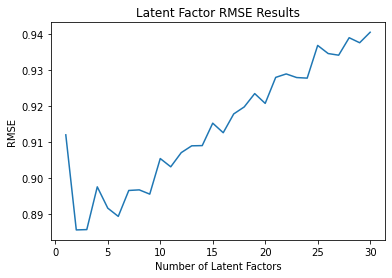

In [ ]:
last_rmse = []
#for i in range(6):
for i in range(len(lst_variables)):
    last_rmse.append(test_loss_hist_list[i][-1])
#plt.plot(lst_variables[:6], last_rmse)
plt.plot(lst_variables, last_rmse)
plt.yticks(np.arange(round(min(last_rmse),2), max(last_rmse), 0.01))
plt.title("Latent Factor RMSE Results")
plt.ylabel("RMSE")
plt.xlabel("Number of Latent Factors")